# A demonstration of controlling models competing in parallel

Controlling competing iterative models in parallel is useful in
optimization. For example, one might try several different
optimization strategies in parallel, and divert resources to the
strategy or strategies that are performing best.

In this toy illustration, several anteaters of varying health
compete for food from a common supply - a stream of random "ant" or
inedible "seed" items. An anteater's `health` attribute is the
probability he is able to successfully catch an ant when the
source makes it available.

If an anteater's score (the number of ants consumed) falls too far
behind that of the leader, he stops consuming (his "training" stops
early). An anteater also stops if he reaches the specified goal.

Anteaters forage for food in parallel using Julia multi-threading.

In [1]:
using Pkg
Pkg.activate(@__DIR__)
Pkg.instantiate()

  Activating environment at `~/Dropbox/Julia7/MLJ/IterationControl/examples/competing_models/Project.toml`


**Julia version** is assumed to be 1.6.*

In [2]:
using IterationControl
using .Threads
using Random
Random.seed!(123)
using Plots
pyplot(size = (600, 300*(sqrt(5) - 1)))

Plots.PyPlotBackend()

## Create a channel to supply food

In [3]:
N = 1_000_000
food = Channel{String}() do ch
    foreach(i -> put!(ch, rand(["ant", "seed"])), 1:N)
end

[take!(food) for i in 1:3]

3-element Vector{String}:
 "seed"
 "ant"
 "ant"

## Define anteaters and how to "train" them

In [4]:
mutable struct Anteater
    health::Float64        # 0.0 = dead; 1.0 = excellent health
    n::Int                 # number of ants consumed
    Anteater(health) = new(health, 0)
end

function eat!(eater::Anteater)
    take!(food) == "ant" && rand() <= eater.health && (eater.n += 1)
    return eater
end

eat! (generic function with 1 method)

"Training" for `n` iterations means take `n` items from the `food`
 source and try to catch and eat each item if it is an "ant":

In [5]:
function IterationControl.train!(eater::Anteater, n)
    foreach(i->eat!(eater), 1:n)
    return eater
end

## Create a collection of competitors

In [6]:
eaters = [Anteater(0.7), Anteater(0.8), Anteater(0.9), Anteater(1.0)]

4-element Vector{Main.##318.Anteater}:
 Main.##318.Anteater(0.7, 0)
 Main.##318.Anteater(0.8, 0)
 Main.##318.Anteater(0.9, 0)
 Main.##318.Anteater(1.0, 0)

In [7]:
n_eaters = length(eaters);

For recording progress:

In [8]:
history = Float64[];

## Define the controls that will define the rules of the competition

In [9]:
const LEAD_TRIGGERING_DEFEAT = 5
const ANTS_TO_WIN = 100

scores(eaters) = [e.n for e in eaters]

is_too_far_behind(eater) =
    maximum(scores(eaters)) - eater.n > LEAD_TRIGGERING_DEFEAT

has_won(eater) = eater.n >= ANTS_TO_WIN

update_history(::Any) =  append!(history, scores(eaters))

controls = [Step(1),
            Callback(is_too_far_behind, stop_if_true=true),
            Callback(has_won, stop_if_true=true),
            Callback(update_history),
            NumberLimit(1000)]

5-element Vector{Any}:
 Step(1)
 Callback{typeof(Main.##318.is_too_far_behind)}(Main.##318.is_too_far_behind, true, nothing, false)
 Callback{typeof(Main.##318.has_won)}(Main.##318.has_won, true, nothing, false)
 Callback{typeof(Main.##318.update_history)}(Main.##318.update_history, false, nothing, false)
 NumberLimit(1000)

## Run the competition

In [10]:
@sync for e in eaters
    Threads.@spawn IterationControl.train!(e, controls...)
end

[ Info: Stop triggered by a `Callback` control. 
[ Info: Stop triggered by a `Callback` control. 
[ Info: Stop triggered by a `Callback` control. 
[ Info: Stop triggered by a `Callback` control. 


## Plot the results

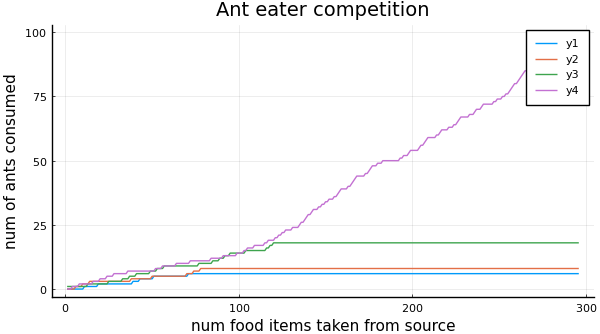

In [11]:
n_events = div(length(history), n_eaters)
history = reshape(history, n_eaters, n_events)'

plot(history,
     title="Ant eater competition",
     ylab="num of ants consumed",
     xlab="num food items taken from source")

---

*This notebook was generated using [Literate.jl](https://github.com/fredrikekre/Literate.jl).*